# Drzewo decyzyjne - Titanic

## Importy

In [1]:
import re
import math
import graphviz
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import tree
from sklearn import model_selection

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
full_data = [train, test]

## Dataset

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Czyszczenie danych i dobór zmiennych

In [4]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

In [5]:
for data in full_data:
    data['HasCabin'] = data['Cabin'].apply(lambda x: 1 if type(x) is str else 0)
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = 0
    data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1
    data['Embarked'] = data['Embarked'].fillna('S')
    data['Fare'] = data['Fare'].fillna(train['Fare'].median())
    
    age_avg = data['Age'].mean()
    age_std = data['Age'].std()
    age_null_count = data['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    data.loc[np.isnan(data['Age']), 'Age'] = age_null_random_list
    data['Age'] = data['Age'].astype(int)
    
    data['Title'] = data['Name'].apply(get_title)
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt','Col','Don', 'Dr', 'Major', 'Rev',
                                           'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    
    data.loc[ data['Fare'] <= 7.91, 'Fare'] = 0
    data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
    data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare'] = 2
    data.loc[ data['Fare'] > 31, 'Fare'] = 3
    
    data.loc[ data['Age'] <= 16, 'Age'] = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[ data['Age'] > 64, 'Age'] = 4
    
train = pd.concat([train, pd.get_dummies(train.Sex, prefix='Sex__')], axis=1)
train = pd.concat([train, pd.get_dummies(train.Embarked, prefix='Embarked__')], axis=1)
train = pd.concat([train, pd.get_dummies(train.Title, prefix='Title__')], axis=1)

test = pd.concat([test, pd.get_dummies(test.Sex, prefix='Sex__')], axis=1)
test = pd.concat([test, pd.get_dummies(test.Embarked, prefix='Embarked__')], axis=1)
test = pd.concat([test, pd.get_dummies(test.Title, prefix='Title__')], axis=1)

In [6]:
pd.get_dummies(train.Title, prefix='Title__').head()

,Title___Master,Title___Miss,Title___Mr,Title___Mrs,Title___Rare
0,0,0,1,0,0
1,0,0,0,1,0
2,0,1,0,0,0
3,0,0,0,1,0
4,0,0,1,0,0


In [7]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Sex', 'Embarked', 'Title']
PassengerId = test['PassengerId']

train = train.drop(drop_elements, axis=1)
test  = test.drop(drop_elements, axis=1)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
Survived          891 non-null int64
Pclass            891 non-null int64
Age               891 non-null int64
Parch             891 non-null int64
Fare              891 non-null float64
HasCabin          891 non-null int64
FamilySize        891 non-null int64
IsAlone           891 non-null int64
Sex___female      891 non-null uint8
Sex___male        891 non-null uint8
Embarked___C      891 non-null uint8
Embarked___Q      891 non-null uint8
Embarked___S      891 non-null uint8
Title___Master    891 non-null uint8
Title___Miss      891 non-null uint8
Title___Mr        891 non-null uint8
Title___Mrs       891 non-null uint8
Title___Rare      891 non-null uint8
dtypes: float64(1), int64(7), uint8(10)
memory usage: 64.5 KB


## Entropia i zysk informacyjny

In [9]:
def entropy(labels):   
    values, counts = np.unique(labels, return_counts=True)
    probs = counts/len(labels)
    classes_number = np.count_nonzero(probs)
    
    ent = -sum(p*math.log(p, 2) for p in probs)
    return ent

In [10]:
def expected_entropy(data, split_col_name, dependent_var_name):
    split_values, split_counts = np.unique(data[split_col_name], return_counts=True)
    
    probs = []
    ent = []
    for value in split_values:
        labels = data[data[split_col_name] == value][dependent_var_name]
        probs.append(len(labels)/len(data[dependent_var_name]))
        ent.append(entropy(labels))
    
    return sum(p*h for p,h in zip(probs, ent))

In [11]:
def information_gain(data, split_col_name, dependent_var_name):
    return entropy(data[dependent_var_name]) - expected_entropy(data, split_col_name, dependent_var_name)
    
    

In [12]:
information_gain(train, 'Title___Mr', 'Survived')

0.22628903828782776

In [13]:
information_gain(train, 'FamilySize', 'Survived')

0.06893376008169061

In [14]:
{col_name: information_gain(train, col_name, 'Survived') for col_name in test.columns}

{'Pclass': 0.0838310452960116,
 'Age': 0.013900047431164575,
 'Parch': 0.02361054763347048,
 'Fare': 0.0649884128100987,
 'HasCabin': 0.07108174174992576,
 'FamilySize': 0.06893376008169061,
 'IsAlone': 0.029708896074360003,
 'Sex___female': 0.2176601066606142,
 'Sex___male': 0.2176601066606142,
 'Embarked___C': 0.019913005288076824,
 'Embarked___Q': 9.595971248610446e-06,
 'Embarked___S': 0.015909401384176403,
 'Title___Master': 0.005063132198816933,
 'Title___Miss': 0.07983401970147563,
 'Title___Mr': 0.22628903828782776,
 'Title___Mrs': 0.08381329437513385,
 'Title___Rare': 0.00010613463714581606}

## K-krotna walidacja krzyżowa i dobór głębokości drzewa

In [15]:
accuracies = []
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)


for depth in depth_range:
    tree_model = tree.DecisionTreeClassifier(max_depth = depth, criterion = 'entropy')
    X_train = train.drop(['Survived'], axis=1)
    y_train = train['Survived']
    
    accuracies.append(model_selection.cross_val_score(tree_model, X_train, y_train, cv=10).mean())
    
    
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
print(df.to_string(index=False))

Max Depth  Average Accuracy
        1          0.782241
        2          0.787985
        3          0.830508
        4          0.821582
        5          0.821645
        6          0.808212
        7          0.798086
        8          0.798073
        9          0.812630
       10          0.810420
       11          0.812605
       12          0.811519
       13          0.819347
       14          0.821619
       15          0.815988
       16          0.812630
       17          0.813741


## Ostateczny model

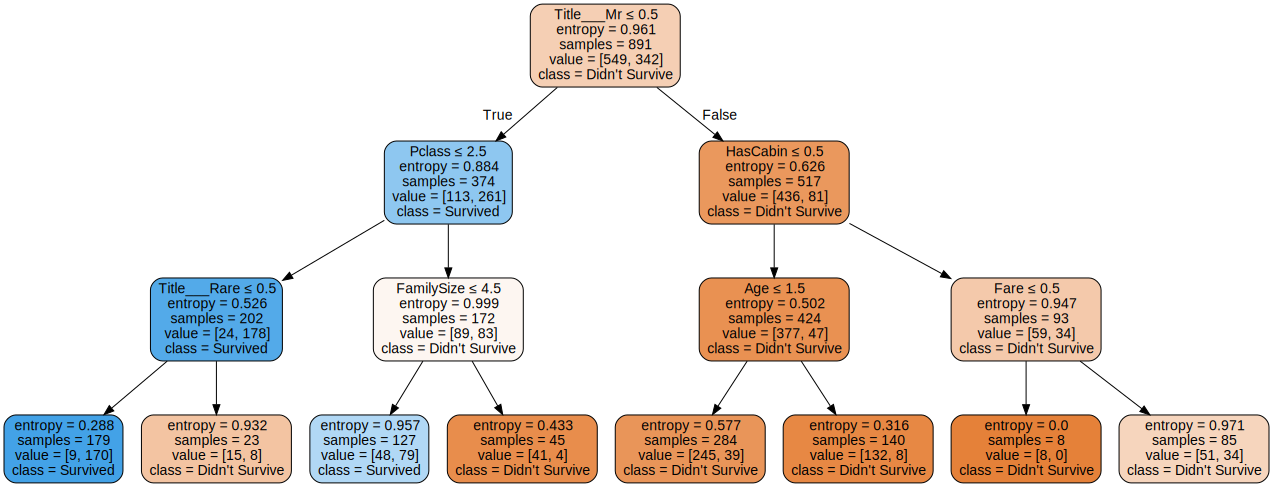

In [16]:
X_train = train.drop(['Survived'], axis=1)
X_test = test.copy()
y_train = train['Survived']


decision_tree = tree.DecisionTreeClassifier(max_depth = 3, criterion = 'entropy')
decision_tree.fit(X_train, y_train)

y_pred_train = decision_tree.predict(X_train)
y_pred = decision_tree.predict(X_test)

submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

tree_data = tree.export_graphviz(decision_tree,
                            out_file=None,
                            feature_names=X_train.columns,
                            class_names=["Didn't Survive", "Survived"],
                            filled=True,
                            rounded=True,
                            special_characters=True)


out = tree_data[0:14] + 'ranksep=.75; size = "20,30";' + tree_data[14:]
graph = graphviz.Source(out)
graph

## Wyniki

In [17]:
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

83.16

In [18]:
pd.DataFrame(metrics.confusion_matrix(y_train,y_pred_train),
             columns = ['Pred_Alive','Pred_Dead'],
             index = ['Act_Alive','Act_Dead'])

,Pred_Alive,Pred_Dead
Act_Alive,492,57
Act_Dead,93,249
